# Prediccion del uso de bicicletas

- Pau Adell Raventos
- Joan Sales De Marcos
- Iván González Reguera
- José Morote García


Primero importamos las librerías que sean necesarias para el proyecto

In [ ]:
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

Cargamos los datos que nos hemos descargado en local de https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [ ]:

def find_folder(folder_name, start_path='/content/drive/My Drive'):
    for root, dirs, files in os.walk(start_path):
        if folder_name in dirs:
            return os.path.join(root, folder_name)
    return None

shared_folder_path = find_folder("APA")

bike_folder_path = os.path.join(shared_folder_path, "bike+sharing+dataset")

def list_contents(directory_path):
    return os.listdir(directory_path)

# For example, to list contents of the bike_folder_path
contents = list_contents(bike_folder_path)
contents

['hour.csv', 'day.csv', 'Readme.txt']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

En este caso usaremos los datos de day.csv el cual contiene lo siguiente:

In [ ]:
day =  pd.read_csv(bike_folder_path + "/day.csv", header=0, delimiter=',')
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Apartado A

Primero eliminaremos determinadas variables leyendo la descripción del dataset en su página web.

Primero vamos a eliminar las variables *instant* y *dteday*, dado que son identificadores. Esto lo podemos comprobar en el campo *unique*, aunque *instant* no lo refleje.

El hecho de que *instant* sea un identificador lo podemos ver a continuación:

In [ ]:
n_unique = day['instant'].nunique()
n_unique

731

Como se puede observar, el método nunique() devuelve la cantidad de valores únicos de la variable *instant*. Podemos ver como el valor devuelvo coincide con la cantidad de muestras que contiene el dataset, por tanto, podemos conlcuir que hay un valor distinto por muestra.

Para acabar, eliminaremos las variables *causal* y *registered*, dado que la variable objetivo *cnt* es la suma de estas dos variables, y no tiene sentido intentar predecir una variable cuando es el resultado de la suma dos variables que utilizaríamos para la predicción.

In [ ]:
day = day.drop(columns=['instant', 'dteday', 'registered', 'casual'])

In [ ]:
day.describe().T

,count,mean,std,min,25%,50%,75%,max
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896
hum,731.0,0.627894,0.142429,0.000000,0.520000,0.626667,0.730209,0.972500


Ahora procederemos a analizar el resto de variables y determinar si es necesario eliminarlas o corregirlas.

### Variables numéricas

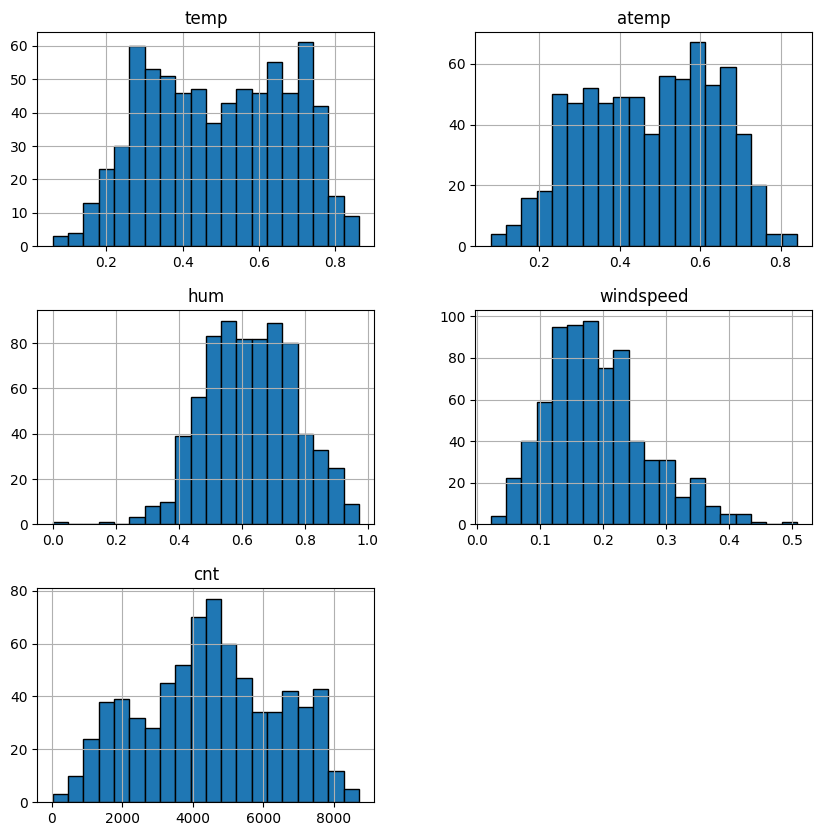

In [ ]:
day.loc[:,['temp', 'atemp', 'hum', 'windspeed', 'cnt']].hist(bins=20, edgecolor='black', figsize=(10,10));

Podemos observar como las variables *temp*, *atemp*, *hum* y *windspeed* se encuentran entre 0 y 1. Eso es por el hecho de que en la descripción del dataset, es comentado que se encuentran normalizadas.

Haciendo la lectura de la descripción del dataset, podemos darnos cuenta de que las variables *atemp* y *temp* ofrecen prácticamente la misma información. Se puede ver su similitud en los histogramas. Decidiremos entre una u otra más adelante.

In [ ]:
numerical_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
days_only_numerical = day[numerical_vars]
days_only_numerical.describe()

,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,4504.348837
std,0.183051,0.162961,0.142429,0.077498,1937.211452
min,0.059130,0.079070,0.000000,0.022392,22.000000
25%,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,0.655417,0.608602,0.730209,0.233214,5956.000000
max,0.861667,0.840896,0.972500,0.507463,8714.000000


<Axes: >

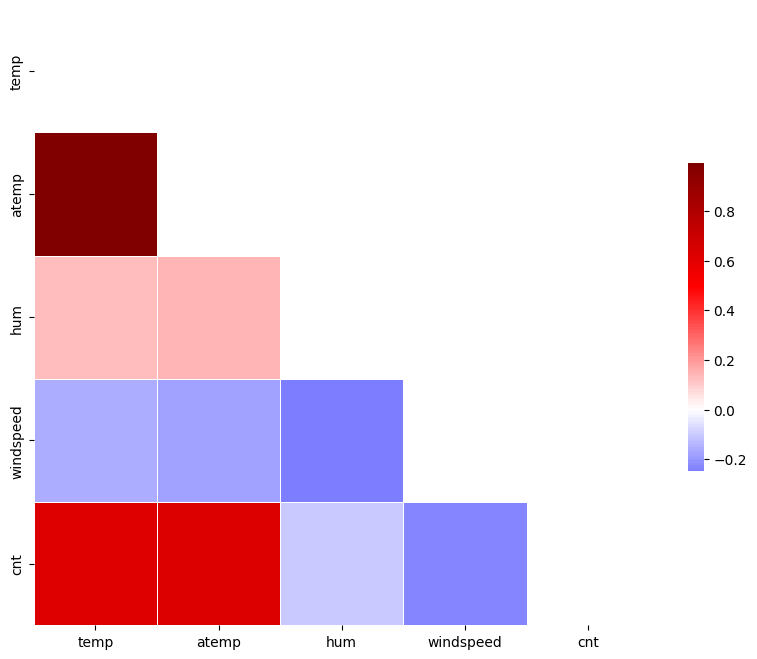

In [ ]:
corr_numericals = days_only_numerical.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_numericals, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_numericals, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr_numericals.loc['cnt', corr_numericals.columns !=  'cnt'].sort_values(ascending=False)

atemp        0.631066
temp         0.627494
hum         -0.100659
windspeed   -0.234545
Name: cnt, dtype: float64

Como hemos mencionado anteriormente, podemos ver cómo las variables *temp* y *atemp* tiene mucha correlación entre ellas, por tanto, elegiremos la que mayor correlación tenga con la variable objetivo, en este caso, *atemp*.

Como observación, podemos ver que la variable *windspeed* tiene correlación negativa, lo que significa que cuanto mayor es la velocidad del viento, menor número de bicicletas hay, lo cual tiene sentido.

Lo mismo pasa con la temperatura pero de manera positiva: cuanta mayor sea la temperatura, mayor es la cantidad de bicicletas usadas.

En conclusión, eliminaremos la variable *temp* por los motivos mencionados en este apartado, y mantendremos el resto de variables.

In [ ]:
day = day.drop(columns=['temp'])

In [ ]:
day.describe().T

,count,mean,std,min,25%,50%,75%,max
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896
hum,731.0,0.627894,0.142429,0.000000,0.520000,0.626667,0.730209,0.972500
windspeed,731.0,0.190486,0.077498,0.022392,0.134950,0.180975,0.233214,0.507463


Ahora pasaremos a analizar las variables categóricas.

### Variables categóricas

Vamos a analizar las variables categóricas con el fin de detectar alguna relación entre ellas y con la variable objetivo count.

cantidad de bicis en 2011: 1243103
cantidad de bicis en 2012: 2049576


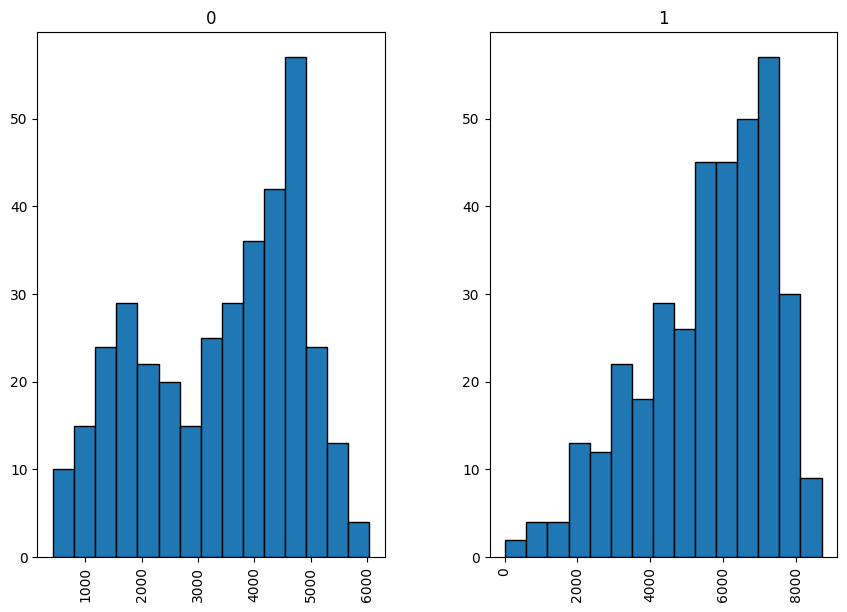

In [ ]:
day.hist(column='cnt',by='yr',bins=15, figsize=(10,7), edgecolor='black');
yr_0 = day[day['yr'] == 0]['cnt'].sum()
yr_1 = day[day['yr'] == 1]['cnt'].sum()
print("cantidad de bicis en 2011:", yr_0)
print("cantidad de bicis en 2012:", yr_1)

Podemos ver que ha habido un incremento en el uso de bicicletas entre los años 2011 (0) y 2012 (1), por tanto podemos suponer que de un año a otro se popularizó, cosa que afectará mucho a las predicciones.

season 1  year 0 : mean = 1666.6666666666667 | sum = 150000
season 2  year 0 : mean = 3775.1739130434785 | sum = 347316
season 3  year 0 : mean = 4464.36170212766 | sum = 419650
season 4  year 0 : mean = 3664.4606741573034 | sum = 326137
------------------------------------------------------------
season 1  year 1 : mean = 3531.296703296703 | sum = 321348
season 2  year 1 : mean = 6209.489130434783 | sum = 571273
season 3  year 1 : mean = 6824.244680851064 | sum = 641479
season 4  year 1 : mean = 5791.865168539326 | sum = 515476


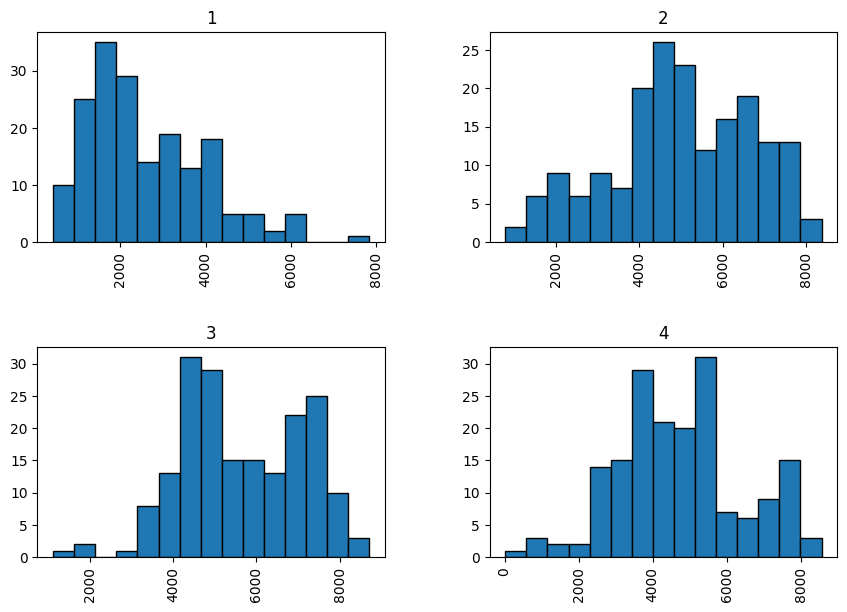

In [ ]:
day.hist(column='cnt',by='season',bins=15, figsize=(10,7), edgecolor='black');

for x in range(1, 5):
    seasons_of_year_0 = day[(day['season'] == x) & (day['yr'] == 0)]
    print("season", x, " year 0 :", "mean =", seasons_of_year_0['cnt'].mean(), "| sum =", seasons_of_year_0['cnt'].sum())

print("------------------------------------------------------------")

for x in range(1, 5):
    seasons_of_year_1 = day[(day['season'] == x) & (day['yr'] == 1)]
    print("season", x, " year 1 :", "mean =", seasons_of_year_1['cnt'].mean(), "| sum =", seasons_of_year_1['cnt'].sum())

Después de analizar las estaciones podemos ver que el uso de bicicletas depende bastante de la estación: En la estación 1 (invierno) se cogen la mitad de bicicletas que en el resto de estaciones, y la estación donde más bicicletas se cogen es en la estación 3 (verano).

También se puede observar como depende mucho del año, como hemos visto anteriormente, dado que en 2012 hay muchas más bicicletas, pero las proporciones entre la cantidad de bicis entre  estaciones del mismo año se mantiene de un año a otro.


month 1 year 0: mean = 1231.9032258064517 | sum = 38189
month 2 year 0: mean = 1721.9642857142858 | sum = 48215
month 3 year 0: mean = 2065.967741935484 | sum = 64045
month 4 year 0: mean = 3162.3333333333335 | sum = 94870
month 5 year 0: mean = 4381.322580645161 | sum = 135821
month 6 year 0: mean = 4783.733333333334 | sum = 143512
month 7 year 0: mean = 4559.387096774193 | sum = 141341
month 8 year 0: mean = 4409.387096774193 | sum = 136691
month 9 year 0: mean = 4247.266666666666 | sum = 127418
month 10 year 0: mean = 3984.2258064516127 | sum = 123511
month 11 year 0: mean = 3405.5666666666666 | sum = 102167
month 12 year 0: mean = 2816.8709677419356 | sum = 87323
--------------------------------------------
month 1 year 1: mean = 3120.7741935483873 | sum = 96744
month 2 year 1: mean = 3556.448275862069 | sum = 103137
month 3 year 1: mean = 5318.548387096775 | sum = 164875
month 4 year 1: mean = 5807.466666666666 | sum = 174224
month 5 year 1: mean = 6318.225806451613 | sum = 195865

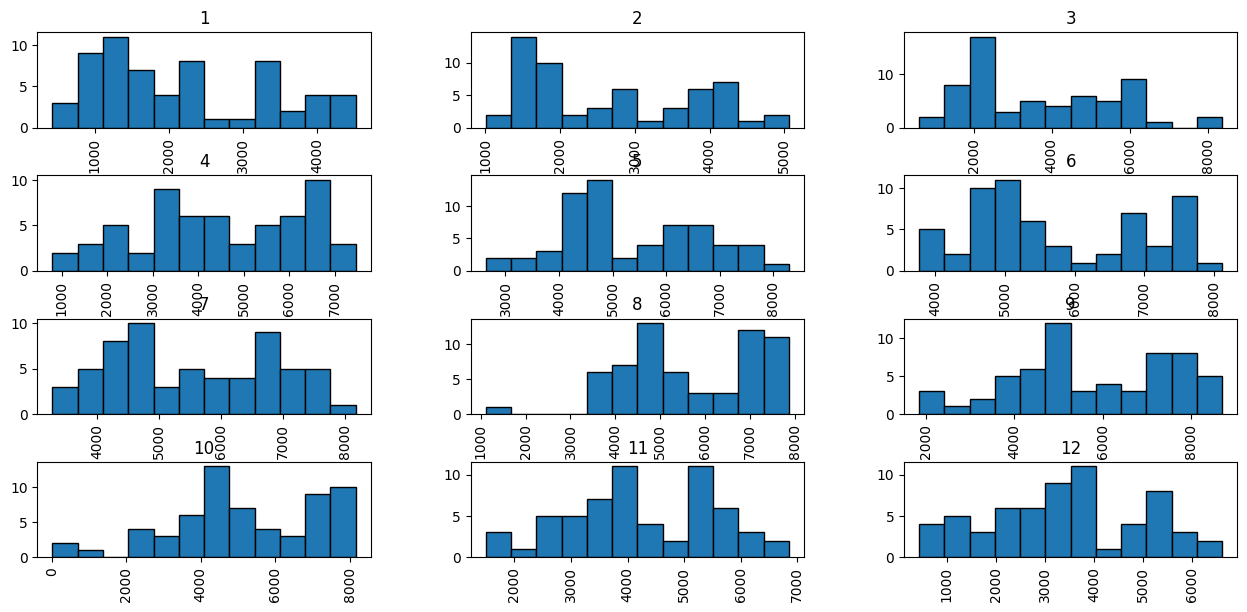

In [ ]:
day.hist(column='cnt',by='mnth',bins=12, figsize=(15,7), edgecolor='black');
# print(day['mnth'].value_counts())

for x in range(1, 13):
    month_of_year_0 = day[(day['mnth'] == x) & (day['yr'] == 0)]
    print("month", x, "year 0:", "mean =", month_of_year_0['cnt'].mean(), "| sum =", month_of_year_0['cnt'].sum())

print("--------------------------------------------")

for x in range(1, 13):
    month_of_year_1 = day[(day['mnth'] == x) & (day['yr'] == 1)]
    print("month", x, "year 1:", "mean =", month_of_year_1['cnt'].mean(), "| sum =", month_of_year_1['cnt'].sum())

Podemos observar cómo los meses con la mayor cantidad de bicis son los pertenecientes a verano (6-7-8), mientras que los meses con menor cantidad de bicis son los pertenecientes a invierno (12-1-2), de la misma manera que con las estaciones.

De hecho, si realizamos la suma de las bicis cogidas para cada año en los meses de cada estación, el resultado es prácticamente igual al de las estaciones para cada año, por tanto, las estaciones en la variable *season* se pueden considerar combinación lineal de los meses en la variable *months*.

Este último factor se puede observar más adelante en el *heatmap*, donde la correlación entre las variables *season* y *mnth* es muy alta, por tanto, podríamos considerar eliminar esta variable, pero dado que dependiendo del mes hay más o menos bicicletas, dejaremos la variable ya que aporta cierta información extra al modelo.

0    710
1     21
Name: holiday, dtype: int64
media de bicis en no dia festivo: 4527.104225352113
media de bicis en dia festivo: 3735.0


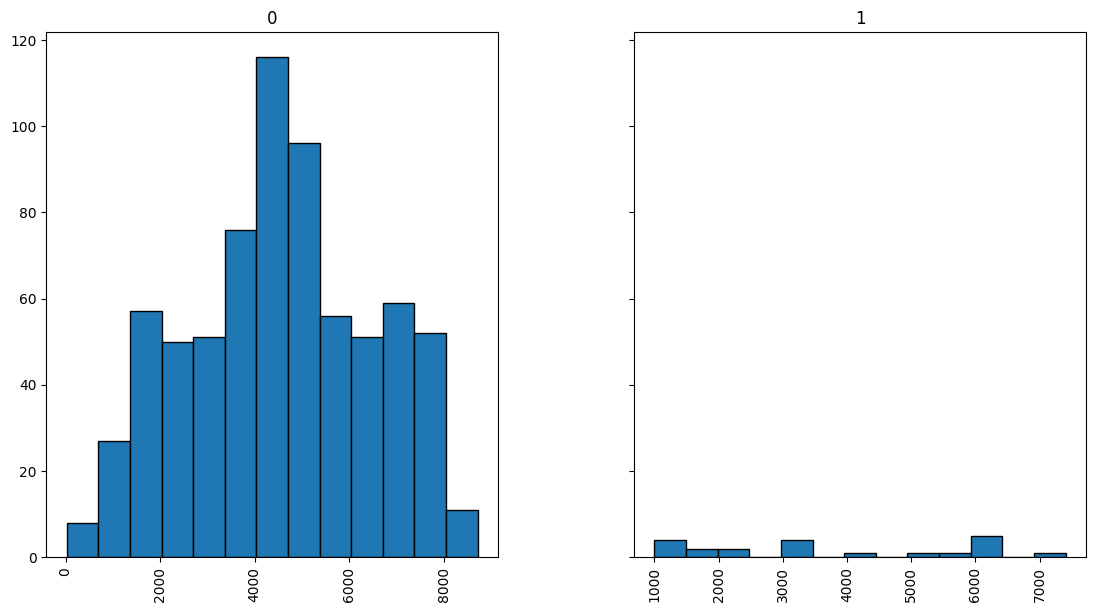

In [ ]:
day.hist(column='cnt',by='holiday',bins=13, figsize=(13,7), sharey=True,edgecolor='black');
print(day['holiday'].value_counts())

f_0 = day[day['holiday'] == 0]['cnt'].mean()
f_1 = day[day['holiday'] == 1]['cnt'].mean()
print("media de bicis en no dia festivo:", f_0)
print("media de bicis en dia festivo:", f_1)

Aquí sí podemos ver una gran diferencia, los días de vacaciones (1) se utilizan muchas menos bicicletas que los días que no lo son(0).

Podemos ver una clara diferencia en la cantidad de bicis en total en los histogramas, pero dado que hay mas días no festivos que festivos, es mejor ver la diferencia con la media de bicis usadas, la cual es muy parecida (4527 bicis de media los dias no festivos contra 3735 los dias festivos), por tanto el hecho de que sea festivo o no, afecta ligeramente en la cantidad de bicis.

day 0  year 0: 177074
day 1  year 0: 180221
day 2  year 0: 180338
day 3  year 0: 169169
day 4  year 0: 174552
day 5  year 0: 182006
day 6  year 0: 179743
----------------------
day 0  year 1: 266953
day 1  year 1: 275282
day 2  year 1: 288771
day 3  year 1: 303879
day 4  year 1: 310843
day 5  year 1: 305784
day 6  year 1: 298064


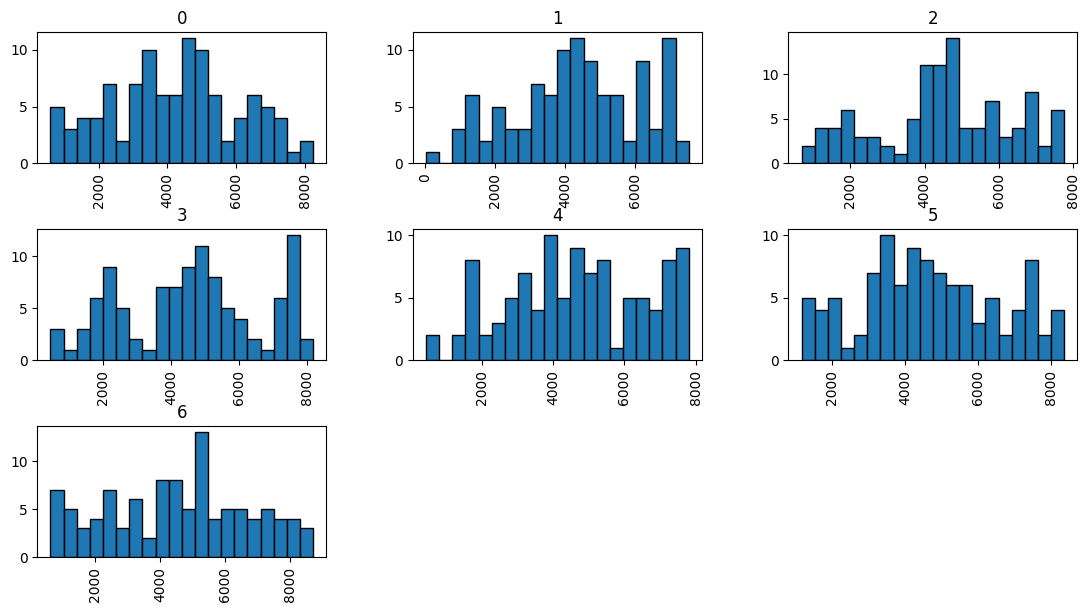

In [ ]:
day.hist(column='cnt',by='weekday',bins=20, figsize=(13,7), edgecolor='black');

for x in range(0, 7):
    weekday_of_year_0 = day[(day['weekday'] == x) & (day['yr'] == 0)]
    print("day", x, " year 0:", weekday_of_year_0['cnt'].sum())

print("----------------------")

for x in range(0, 7):
    weekday_of_year_1 = day[(day['weekday'] == x) & (day['yr'] == 1)]
    print("day", x, " year 1:", weekday_of_year_1['cnt'].sum())

A pesar de que sí que varía de un año a otro, podemos ver que no hay prácticamente diferencias entre el número de bicicletas utilizadas según el día de la semana de un mismo año, es decir, que las relaciones se mantienen de un año a otro, como lleva pasando estas últimas variables.




1    500
0    231
Name: workingday, dtype: int64
cantidad de bicis en dia que no se trabaja: 4330.168831168831
cantidad de bicis en dia que se trabaja: 4584.82


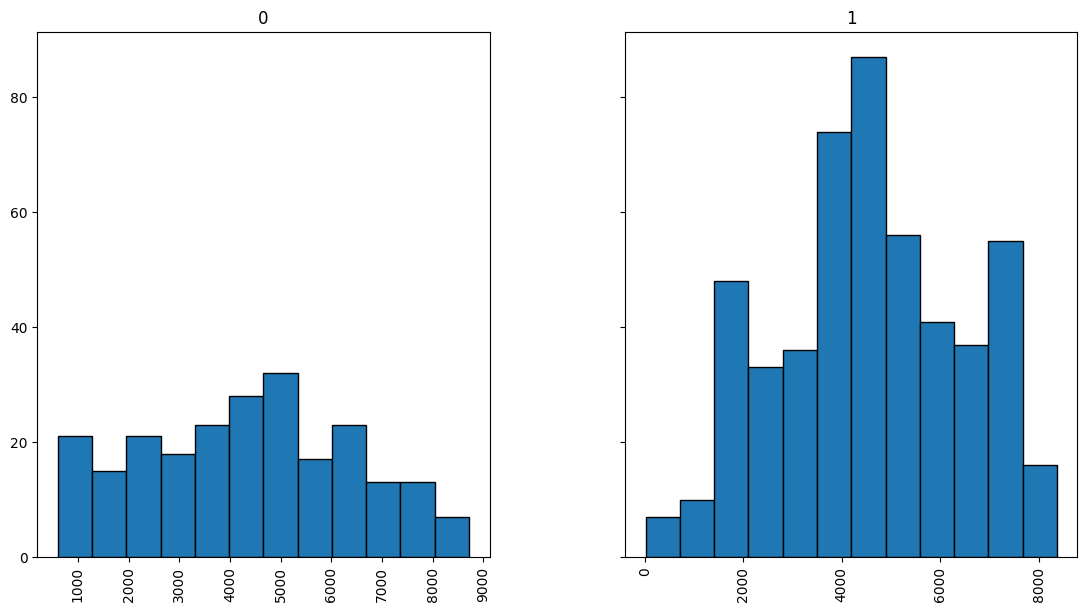

In [ ]:
day.hist(column='cnt',by='workingday',bins=12, figsize=(13,7), sharey= True, edgecolor='black');
print(day['workingday'].value_counts())

mean_bicis_wd_0 = day[day['workingday'] == 0]['cnt'].mean()
mean_bicis_wd_1 = day[day['workingday'] == 1]['cnt'].mean()
print("cantidad de bicis en dia que no se trabaja:", mean_bicis_wd_0)
print("cantidad de bicis en dia que se trabaja:", mean_bicis_wd_1)

Primero hay que explicar que workday es 0 cuando es un día laborable y es 1 cuando no lo es (vacaciones o fin de semana).

Podemos observar con la media que se repite la misma situación que con la variable *holiday*.

Se podría considerar eliminar *holiday* o *workingday* dado que la información que proporcionan es prácticamente la misma, pero hay que distinguir entre festivo y fin de semana, por tanto dejaremos las dos variables.

2257952
996858
37869


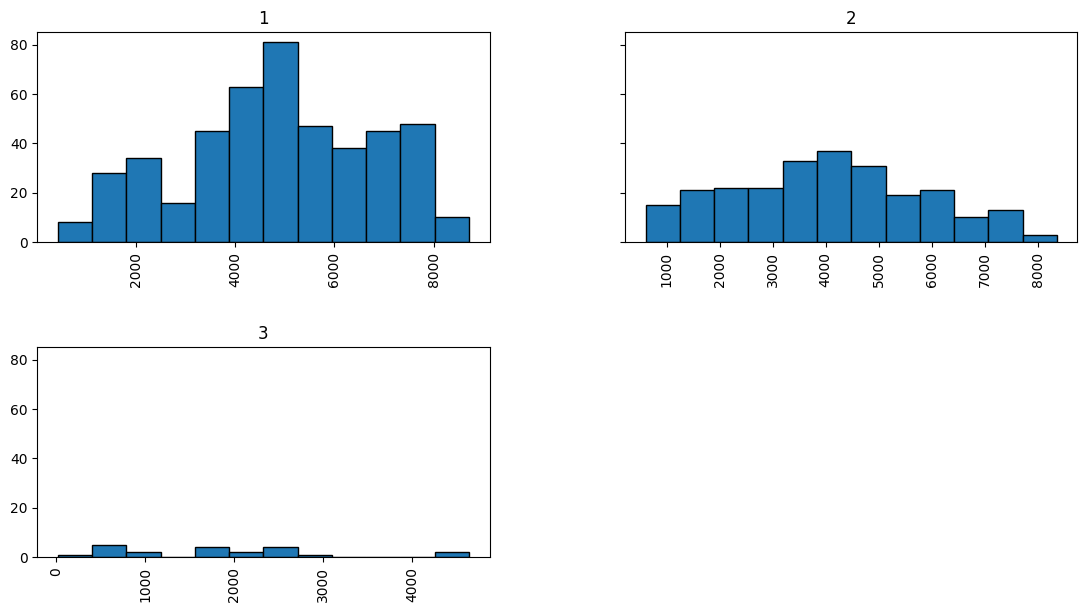

In [ ]:
day.hist(column='cnt',by='weathersit',bins=12, figsize=(13,7), sharey = True, edgecolor='black');

for x in range(1, 4):
    print(day[day['weathersit'] == x]['cnt'].sum())

Podemos ver que cuando el día está despejado o con pocas nubes (1) el uso de bicicletas es muy alto, sin embargo cuando hay lluvia (3) el número de bicis es muy bajo. En caso de haber algo de nubes + niebla (2), es un valor intermedio entre despejado y lluvia, por tanto, la cantidad de bicis usadas depende mucho del temporal que haga.

A continuación, veremos la correlación de estas variables categóricas entre ellas y con la variable objetivo.

In [ ]:
categorical_vars = ['season', 'mnth', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'cnt']
days_only_categorical = day[categorical_vars]
days_only_categorical.describe().T

,count,mean,std,min,25%,50%,75%,max
season,731.0,2.496580,1.110807,1.0,2.0,3.0,3.0,4.0
mnth,731.0,6.519836,3.451913,1.0,4.0,7.0,10.0,12.0
yr,731.0,0.500684,0.500342,0.0,0.0,1.0,1.0,1.0
holiday,731.0,0.028728,0.167155,0.0,0.0,0.0,0.0,1.0
weekday,731.0,2.997264,2.004787,0.0,1.0,3.0,5.0,6.0
workingday,731.0,0.683995,0.465233,0.0,0.0,1.0,1.0,1.0
weathersit,731.0,1.395349,0.544894,1.0,1.0,1.0,2.0,3.0
cnt,731.0,4504.348837,1937.211452,22.0,3152.0,4548.0,5956.0,8714.0


<Axes: >

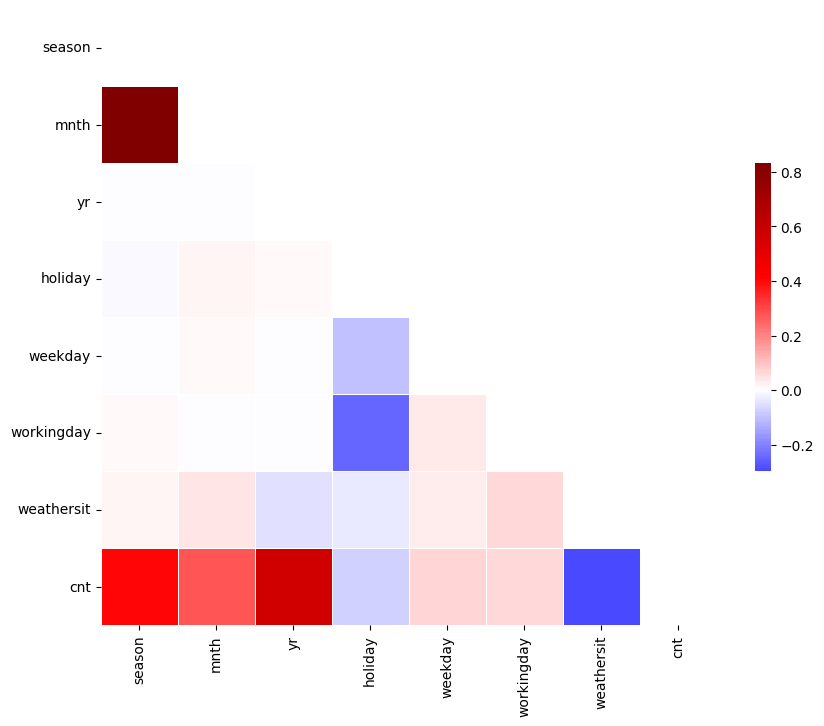

In [ ]:
corr_categoricals = days_only_categorical.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_categoricals, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_categoricals, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr_categoricals.loc['cnt', corr_categoricals.columns !=  'cnt'].sort_values(ascending=False)

yr            0.566710
season        0.406100
mnth          0.279977
weekday       0.067443
workingday    0.061156
holiday      -0.068348
weathersit   -0.297391
Name: cnt, dtype: float64

En conclusión, contrastando con el heatmap recién generado, podemos ver cómo ninguna de las variables, a excepción de la variable objetivo, tiene correlación con la variable *yr*, lo que significa que según el año hay más bicicletas o menos, pero dentro de las variables este hecho no afecta ya que las proporciones se mantienen.

También es visible la gran correlación entre *season* y *mnth*, tal como se ha mencionado anteriormente.

Por tanto, después de eliminar la variable

- *weekday*: no hay diferencia en la cantidad de bicicletas según el dia, por tanto, la variable es redundante

el heatmap queda asi:

In [ ]:
day = day.drop(columns=['weekday'])

In [ ]:
categorical_vars = ['season', 'yr', 'workingday', 'weathersit', 'holiday', 'mnth', 'cnt']
days_only_categorical = day[categorical_vars]
days_only_categorical.describe()

,season,yr,workingday,weathersit,holiday,mnth,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,0.683995,1.395349,0.028728,6.519836,4504.348837
std,1.110807,0.500342,0.465233,0.544894,0.167155,3.451913,1937.211452
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,22.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,4.000000,3152.000000
50%,3.000000,1.000000,1.000000,1.000000,0.000000,7.000000,4548.000000
75%,3.000000,1.000000,1.000000,2.000000,0.000000,10.000000,5956.000000
max,4.000000,1.000000,1.000000,3.000000,1.000000,12.000000,8714.000000


<Axes: >

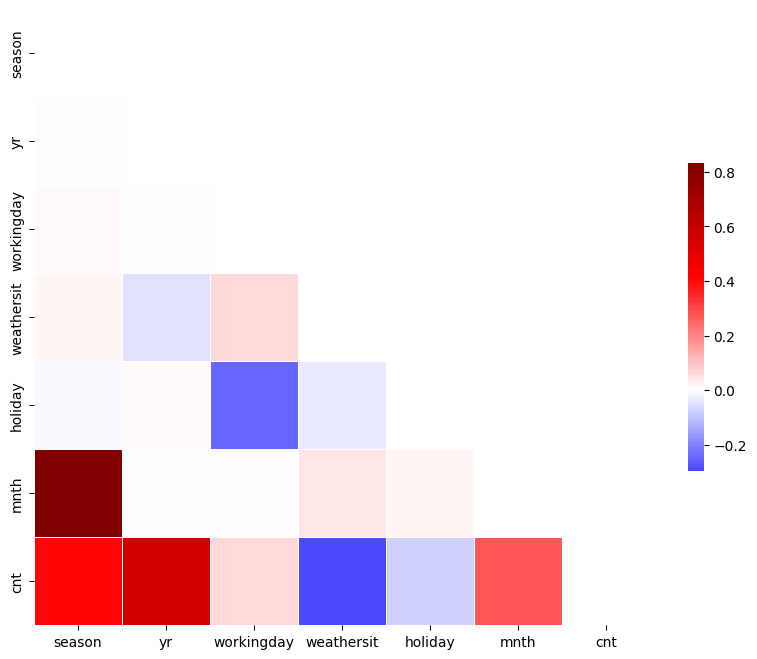

In [ ]:
corr_categoricals = days_only_categorical.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_categoricals, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_categoricals, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Correlación final entre todas las variables

El heatmap resultante de todas las eliminaciones de variables es el siguiente:

<Axes: >

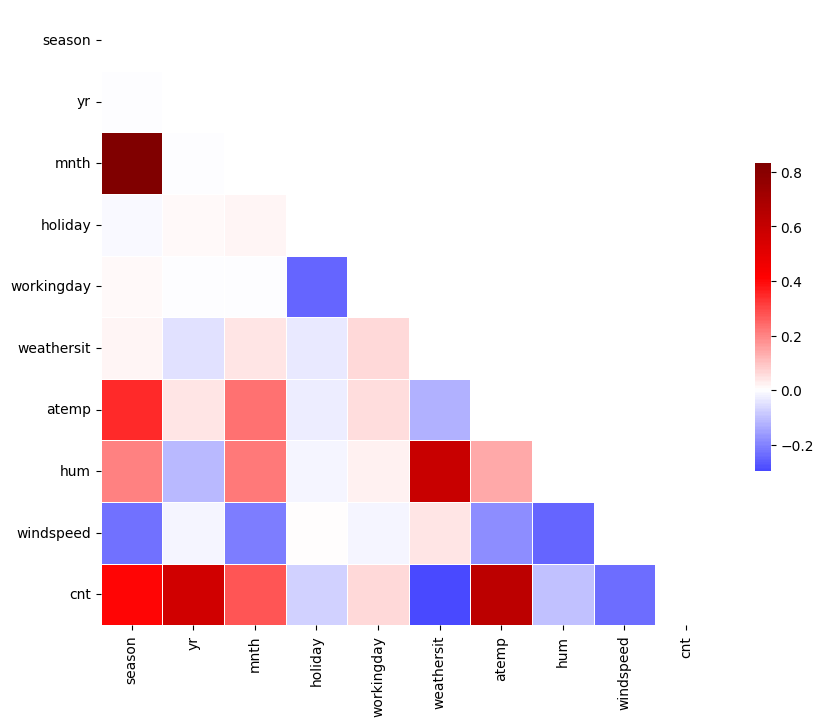

In [ ]:
corr = day.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr.loc['cnt', corr.columns !=  'cnt'].sort_values(ascending=False)

atemp         0.631066
yr            0.566710
season        0.406100
mnth          0.279977
workingday    0.061156
holiday      -0.068348
hum          -0.100659
windspeed    -0.234545
weathersit   -0.297391
Name: cnt, dtype: float64

Como podemos observar, las variables con más correlación con la variable objetivo son *season*, *yr* y *atemp*.

También podemos observar grandes correlaciones entre variables numéricas y categóricas, como por ejemplo *season-atemp* (según la estación del año hara más o menos frio) o *hum-weathersit* (por ejemplo, días lluviosos hará más humedad, mientras que si no llueve lo más probable es dia seco).

Dada la baja correlación de la humedad con la variable objetivo, podemos considerar que la humedad será explicada por la variable *weathersit*, e incluso por la variable *windspeed* (cuanto mas aire menos humedad), pero después de una serie de experimentos, nos damos cuenta de que aporta cierta información adicional, la cual veremos más adelate en la asignación de pesos de los modelos.

Heatmap final:

<Axes: >

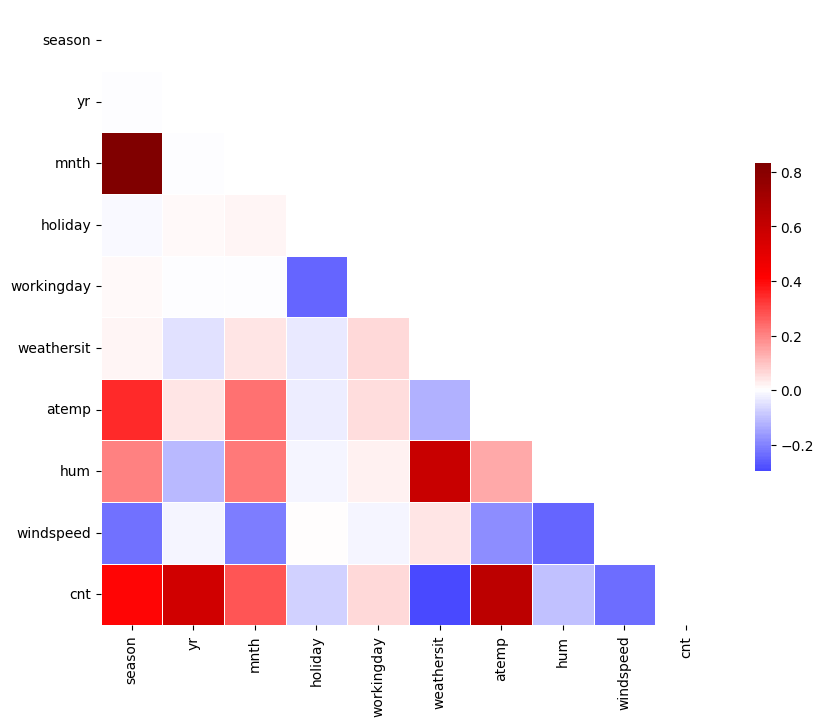

In [ ]:
corr = day.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### One-hot encoding

El primer paso será recodificar las variables categóricas restantes que no sean binarias con one-hot encoding, con el objetivo de no dar importancia a números más grandes.

In [ ]:
variables_to_one_hot = ['weathersit', 'season', 'mnth']
for var in variables_to_one_hot:
  dummies = pd.get_dummies(day[var], drop_first=True, prefix=var, dtype=int)
  day = day.merge(dummies, left_index=True, right_index=True)
  day = day.drop(columns=[var])

day.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,weathersit_2,weathersit_3,season_2,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,0,0,0,0.363625,0.805833,0.160446,985,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0.353739,0.696087,0.248539,801,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0.189405,0.437273,0.248309,1349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0.212122,0.590435,0.160296,1562,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0.229270,0.436957,0.186900,1600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Valores perdidos
Podemos observar que no hay valores perdidos

In [ ]:
day.isna().sum()

yr              0
holiday         0
workingday      0
atemp           0
hum             0
windspeed       0
cnt             0
weathersit_2    0
weathersit_3    0
season_2        0
season_3        0
season_4        0
mnth_2          0
mnth_3          0
mnth_4          0
mnth_5          0
mnth_6          0
mnth_7          0
mnth_8          0
mnth_9          0
mnth_10         0
mnth_11         0
mnth_12         0
dtype: int64

### Valores extremos

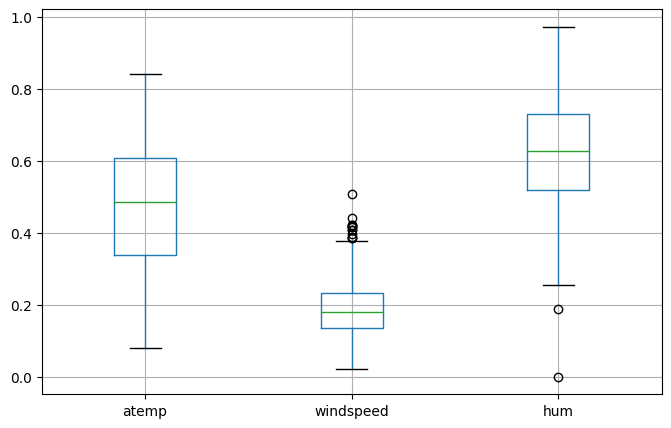

In [ ]:
data_columns = ['atemp', 'windspeed', 'hum']
fig, ax = plt.subplots(figsize=(8,5));
day[data_columns].boxplot();

Se puede ver cómo la variable windspeed contiene valores extremos.

Consideraremos que no hay que corregir estos casos, ya que no sigue una distribución gausiana, y porque los valores extremos referentes a la velocidad del viento nos pueden aportar información, dado que si hay rachas de viento muy fuertes, la gente no cogería la bicicleta, por eso pueden ser relevantes estos valores extremos.

La variable hum también contiene algún valor extremo, pero, como en el caso de windspeed, nos puede aportar cierta información adicional, por tanto consideramos dejarlos en el dataset.

# División de los datos
Separamos las variables por entreno (60%) y test (40%)

In [ ]:
y = day['cnt']
X = day.loc[:, day.columns != 'cnt']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((511, 22), (511,), (220, 22), (220,))

El número de variables que usaremos de entrenamiento y para poner a prueba seran las siguientes:

### Estandarización de las variables

Procedemos a estandarizar las variables numéricas atemp y windspeed, ajustando el estandarizador con el set de training, y luego aplicando el mismo estandarizador al set de test.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columnas_a_estandarizar = ['atemp', 'windspeed', 'hum']
X_train[columnas_a_estandarizar] = scaler.fit_transform(X_train[columnas_a_estandarizar])

X_train.describe()

,yr,holiday,workingday,atemp,hum,windspeed,weathersit_2,weathersit_3,season_2,season_3,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
count,511.000000,511.000000,511.000000,5.110000e+02,5.110000e+02,5.110000e+02,511.000000,511.000000,511.000000,511.000000,...,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.518591,0.027397,0.649706,-5.144830e-16,3.615286e-16,1.077633e-16,0.342466,0.029354,0.258317,0.256360,...,0.064579,0.084149,0.095890,0.080235,0.086106,0.080235,0.086106,0.093933,0.078278,0.078278
std,0.500144,0.163398,0.477529,1.000980e+00,1.000980e+00,1.000980e+00,0.474999,0.168963,0.438138,0.437051,...,0.246023,0.277883,0.294729,0.271923,0.280795,0.271923,0.280795,0.292022,0.268872,0.268872
min,0.000000,0.000000,0.000000,-2.489140e+00,-4.501933e+00,-2.207559e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-8.043111e-01,-7.649477e-01,-7.276947e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.722396e-01,3.028258e-02,-1.358894e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,8.104916e-01,7.170665e-01,5.835475e-01,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2.235509e+00,2.336351e+00,3.333564e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_test[columnas_a_estandarizar] = scaler.transform(X_test[columnas_a_estandarizar])
X_test.describe()

,yr,holiday,workingday,atemp,hum,windspeed,weathersit_2,weathersit_3,season_2,season_3,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.459091,0.031818,0.763636,-0.125232,-0.135991,0.048252,0.327273,0.027273,0.236364,0.259091,...,0.131818,0.077273,0.059091,0.086364,0.081818,0.095455,0.072727,0.063636,0.090909,0.100000
std,0.499460,0.175916,0.425817,1.029717,1.032926,1.078630,0.470288,0.163248,0.425817,0.439135,...,0.339064,0.267633,0.236333,0.281541,0.274713,0.294512,0.260281,0.244661,0.288135,0.300684
min,0.000000,0.000000,0.000000,-2.248138,-3.166837,-1.878621,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,-1.019997,-0.908873,-0.701114,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,-0.137097,-0.213945,-0.065986,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.749604,0.569056,0.560143,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.949813,2.407398,4.204712,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Apartado B

# Reducción de dimensionalidad

En este caso hemos elegido usar el metodo de PCA para reducir la dimensionalidad en los datos de entrenamiento. Gracias al apartado anterior las variables están estandarizadas.

In [ ]:
pca = PCA().fit(X_train)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.28587462 0.19925277 0.15068369 0.0621527  0.04953968 0.04465823
 0.0432956  0.02869326 0.0174792  0.01699037 0.01635364 0.01594551
 0.01569872 0.01458683 0.01312846 0.00889179 0.0049742  0.00429912
 0.00296071 0.00267731 0.0015492  0.00031441]
[0.28587462 0.48512739 0.63581108 0.69796378 0.74750346 0.79216169
 0.83545729 0.86415055 0.88162975 0.89862012 0.91497376 0.93091927
 0.94661798 0.96120481 0.97433326 0.98322505 0.98819925 0.99249838
 0.99545909 0.99813639 0.99968559 1.        ]


Usaremos la relación de varianza explicada y los valores singulares para decidir los componentes a conservar. Como podemos ver si conservamos 3 componentes ya obtenemos algo más del 0.8 de varianza acumulada, este valor se suele utilizar como mínimo para saber cuántos componentes conservar. Si tuviéramos más valores el número de componentes a conservar sería mayor.

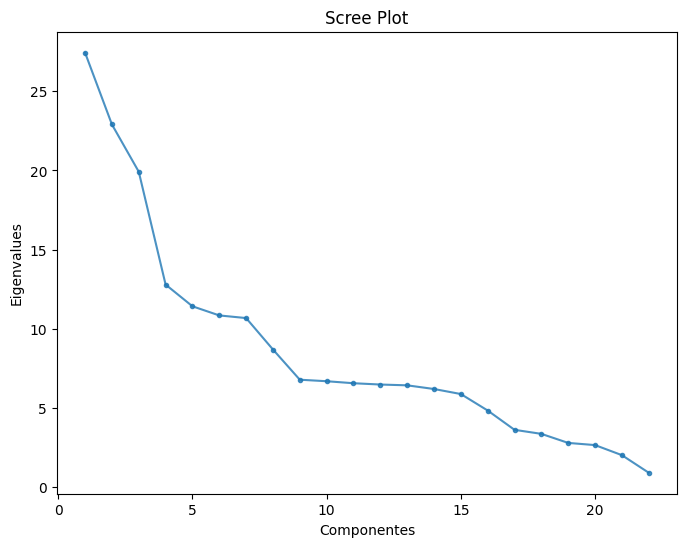

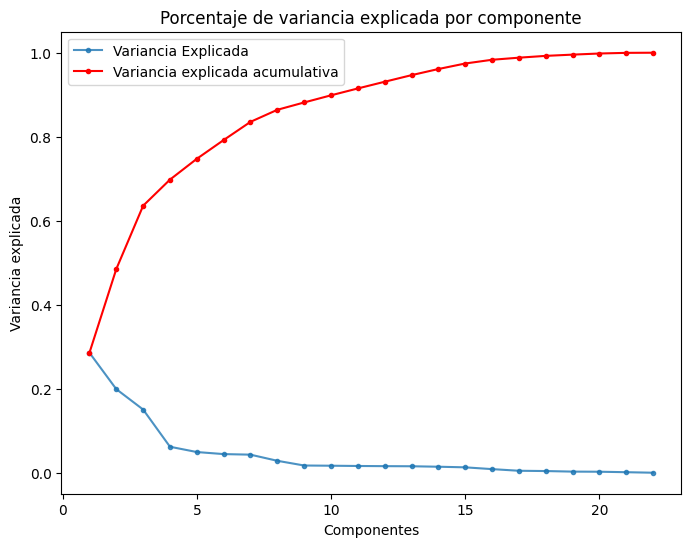

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.singular_values_ )+1),pca.singular_values_ ,alpha=0.8,marker='.');

y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');

plt.title("Scree Plot");


fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');



Podemos ver en los gráficos anteriores tanto el número de valores singulares como el porcentaje de varianza explicada según el número de componentes.

A continuación también podemos observar los diferentes pesos que le asigna el PCA a cada componente.

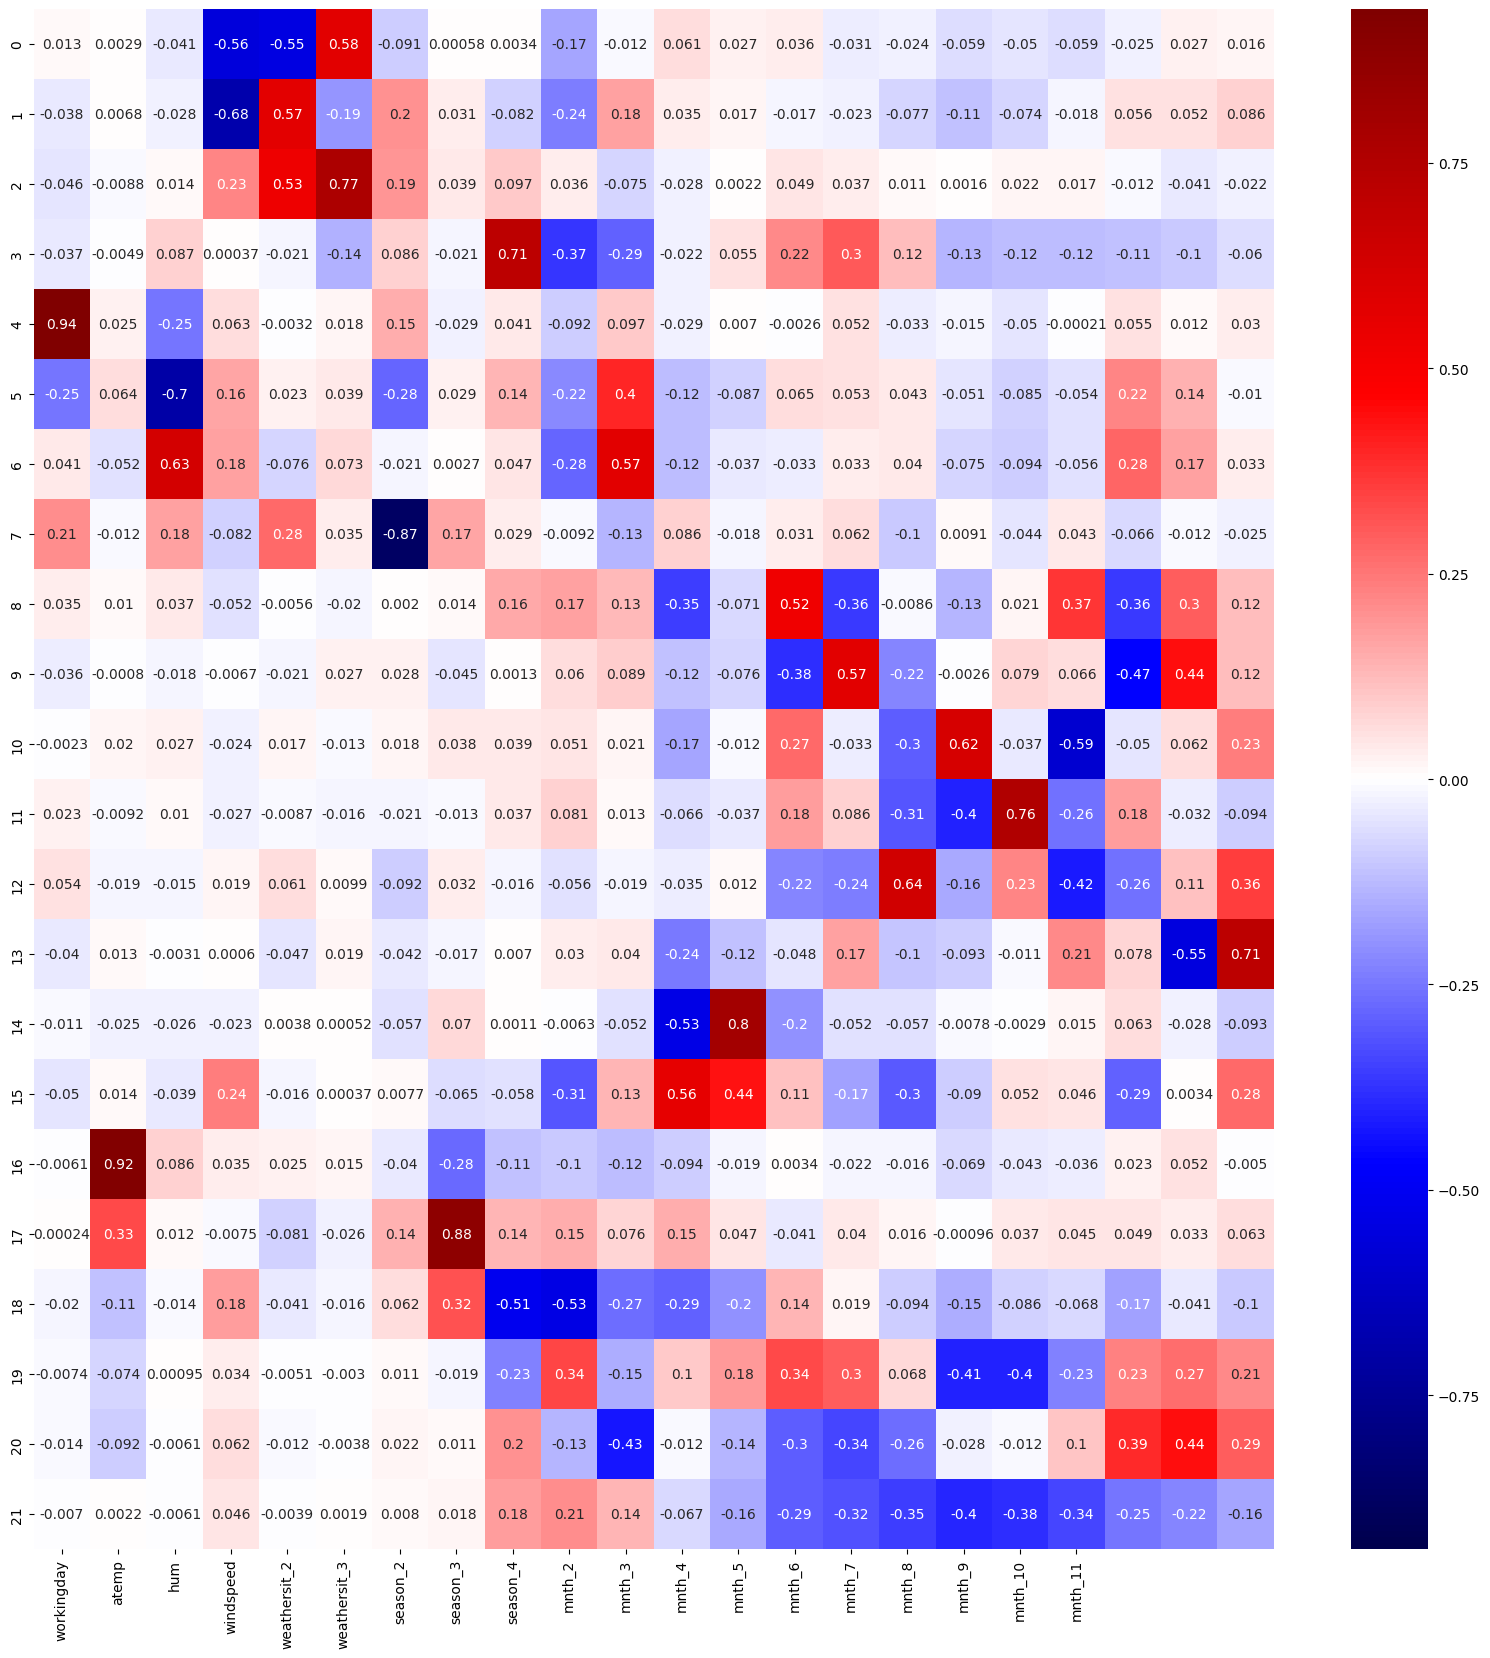

In [ ]:
plt.subplots(figsize=(20, 20))
sns.heatmap(pca.components_, cmap='seismic',
            xticklabels=list(X_train.columns[2:-1]),
            vmin=-np.max(np.abs(pca.components_)),
            vmax=np.max(np.abs(pca.components_)),
            annot=True);

Ahora transformaremos nuestro conjunto de datos utilizando el PCA "entrenado".

Utilizaremos solo 2 componentes para la visualización.

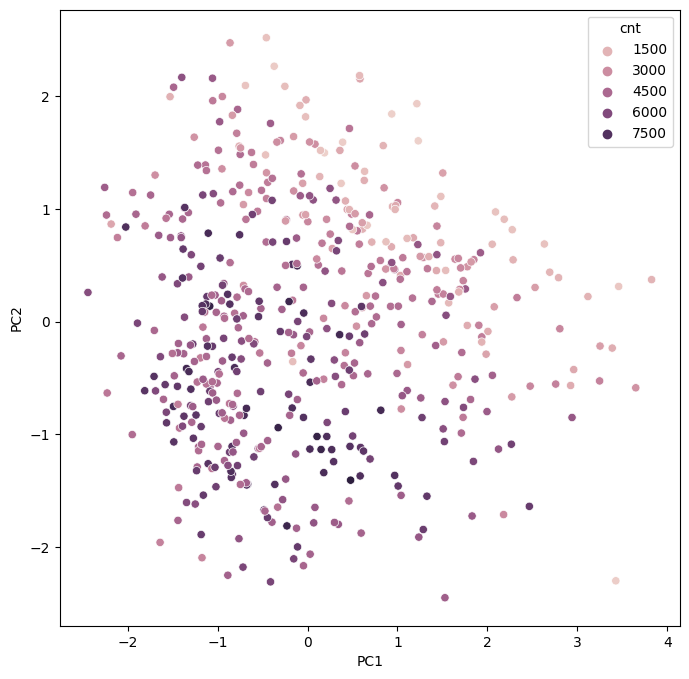

In [ ]:
transformed_bici = pca.transform(X_train[X_train.columns])
copy_train = X_train.copy()
copy_train[['PC1','PC2', 'PC3']] = transformed_bici[:,:3]
fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', hue=y_train, data=copy_train)


Y a continuación lo podemos ver en 3D.

In [ ]:
import plotly.express as px
fig = px.scatter_3d(copy_train, x='PC1', y='PC2', z='PC3',
              color=y_train)
fig.show()

En esta última representación podemos ver algo mejor los distintos rangos de la variable objetivo. Se pueden ver diversas nubes con rangos de 8000 a 6000 a la izquierda y luego por el centro encontramos las nubes con los rangos de 5000 a 3000 y otra nube con los rangos de 0 a 2000. Después finalmente hacia la derecha volvemos a encontrarnos nubes con valores bajos de nuevo

# Apartado C

En este apartado procederemos a utilizar un regresor con el objetivo de predecir la cantidad de bicicletas.

El regresor utilizado será PoissonRegressor, con validación cruzada.

Lo ajustaremos con el set de training y calcularemos la calidad del modelo con el set de test.


In [ ]:
from sklearn.linear_model import PoissonRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

alphas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,40,50,55,70,75,80,85,100]
#lambdas = np.linspace(0, 100, 500)
cv_metrics = pd.DataFrame(columns=['mean_r2'])

best_r2_score = 0
best_alpha = -1

for alpha in alphas:
    kf = KFold(n_splits=5)

    r2_score_array = []
    nmse_array = []
    mse_array = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        X_test_fold = X_train.values[test_index, :]
        y_test_fold = y_train.values[test_index]

        lr_cv = PoissonRegressor(alpha=alpha, max_iter=500)
        lr_cv.fit(X_train_fold, y_train_fold)
        y_pred_fold = lr_cv.predict(X_test_fold)

        fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)

        r2_score_array.append(fold_r2)
        mse_array.append(fold_mse)
        nmse_array.append(fold_nmse)


    cv_metrics.loc[f'Lambda={alpha}', :] = [np.mean(r2_score_array)]
    if np.mean(r2_score_array) > best_r2_score:
        best_r2_score = np.mean(r2_score_array)
        best_alpha = alpha

print(best_alpha)
cv_metrics.sort_values(by='mean_r2', ascending=False)[:10]

10


,mean_r2
Lambda=10,0.784321
Lambda=5,0.784187
Lambda=1,0.783358
Lambda=0.5,0.78318
Lambda=0.1,0.783019
Lambda=0.01,0.782981
Lambda=0.001,0.782977
Lambda=0.0001,0.782977
Lambda=40,0.779716
Lambda=50,0.777866


In [ ]:
print(np.mean(np.array(r2_score_array)))
print(np.mean(np.array(mse_array)))
print(np.mean(np.array(nmse_array)))

0.7696956962238406
814654.077223313
0.2303043037761594


Probando varias alphas hemos determinado que el mejor rango de valores son los especificados en los vectores, y que según la que sea usada el error varía.

In [ ]:
pr_val = PoissonRegressor(alpha=best_alpha, max_iter=500)
pr_val.fit(X_train, y_train)
pr_y_pred_val = pr_val.predict(X_test)
pr_r2_val = r2_score(y_test, pr_y_pred_val)
pr_mse_val = mean_squared_error(y_test, pr_y_pred_val)
pr_nmse_val =  1-r2_score(y_test, pr_y_pred_val)
print("R2 test set:", pr_r2_val)
print("MSE test set:", pr_mse_val)
print("NMSE test set:", pr_nmse_val)

R2 test set: 0.8255150632975237
MSE test set: 694269.6440621315
NMSE test set: 0.17448493670247633


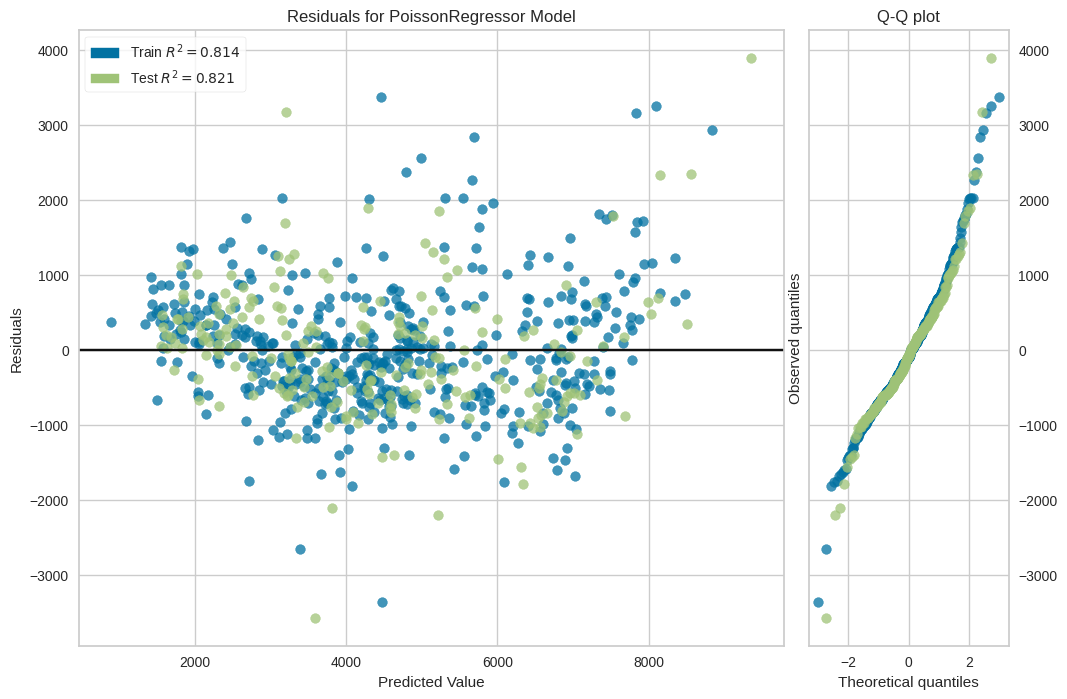

In [ ]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz = residuals_plot(pr_val, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

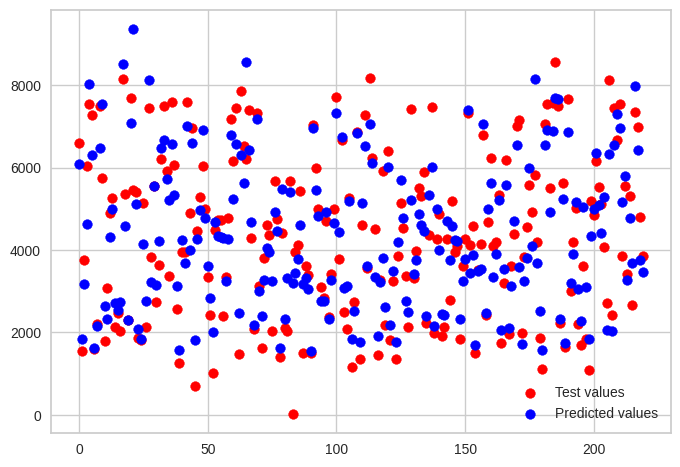

In [ ]:
plt.scatter(range(0, len(y_test)), y_test, color="red")
plt.scatter(range(0, len(pr_y_pred_val)), pr_y_pred_val, color="blue")
plt.legend(['Test values', 'Predicted values'])
plt.show()

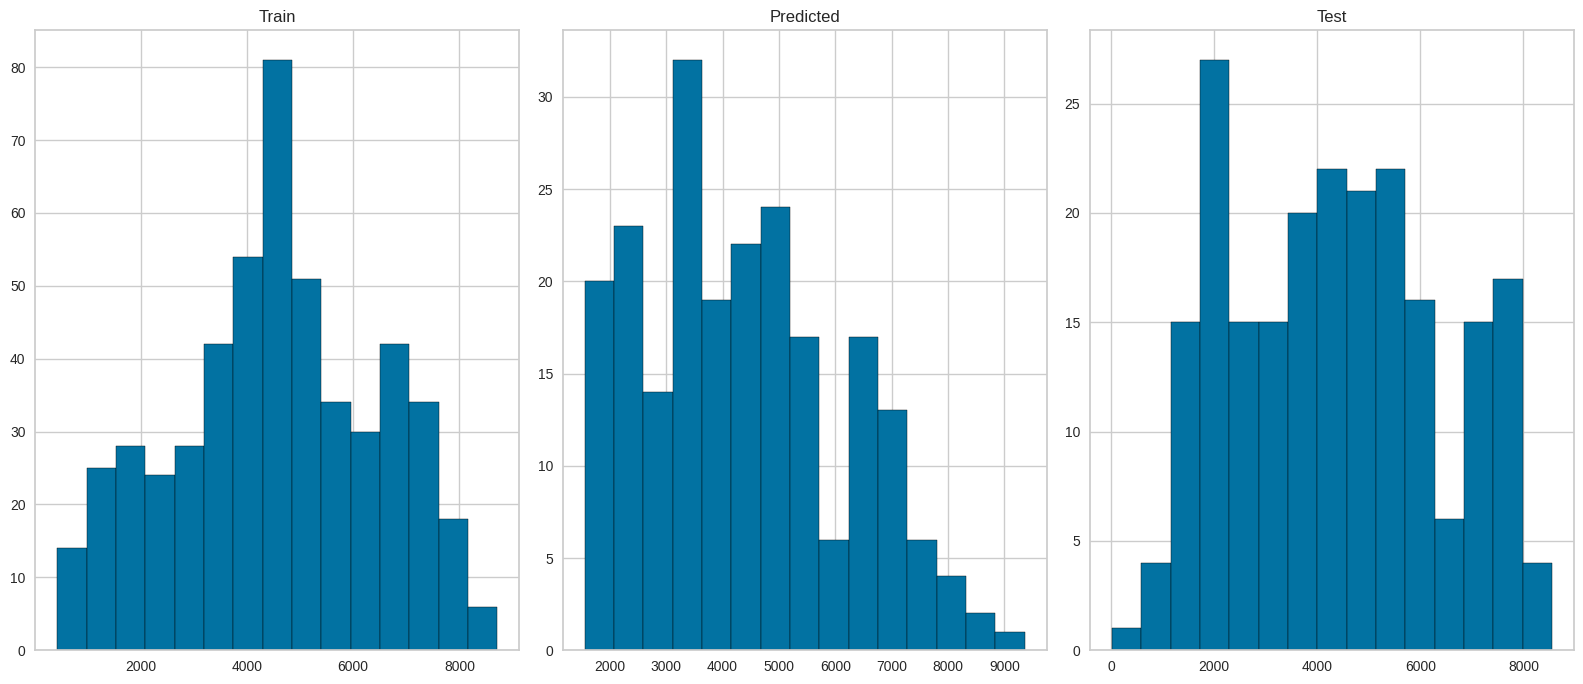

In [ ]:
pr_y_pred_val = pd.Series(pr_y_pred_val);

plt.figure(figsize=(16, 7));

plt.subplot(1, 3, 1);
plt.title("Train");
y_train.hist(bins=15, edgecolor='black');

plt.subplot(1, 3, 2,);
plt.title("Predicted");
pr_y_pred_val.hist(bins=15, edgecolor='black');

plt.subplot(1, 3, 3);
plt.title("Test");
y_test.hist(bins=15, edgecolor='black');

plt.tight_layout();

Podemos observar cómo hemos obtenido un R2 score de 0.825 en el set de test, lo cuál está bastante bien.

Viendo el QQ plot y el scatter plot, podemos observar el parecido de los valores de test con los valores predecidos por el modelo.

También podemos observar el parecido del histograma de predicción con los histogramas de training y test, lo cuál también es un buen indicador del rendimiento del modelo entrenado.


# Calculo de la calidad del modelo (D)

En este apartado ajustaremos una regresion lineal a los datos y calcularemos la calidad del modelo empleando validación cruzada y con los datos de test. Usaremos la libreria de scikit-learn.

In [ ]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

En este caso usaremos validación cruzada sobre la partición de entrenamiento para decidir los hiperparámetros:



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Regresion lineal

In [ ]:
# Instanciamos el modelo LinearRegression
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict
y_pred = lr.predict(X_test);

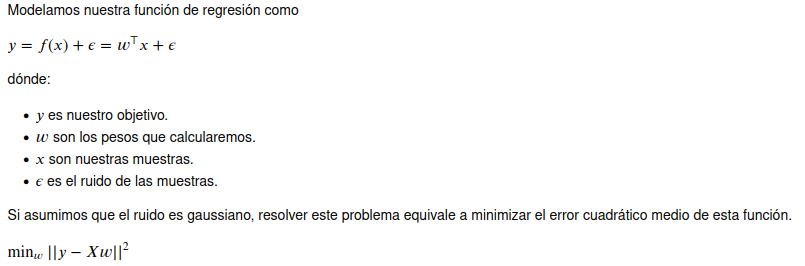

In [ ]:
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [ 1949.485652    -503.24118059   121.19727836  5645.2947841
 -1514.06991118 -2257.58618859  -513.1678124  -1743.62629323
  1014.5404266   1070.39352399]
Interceptor: 
 1343.324046075979


El siguiente gráfico representa los residuos del entrenamiento y el test con el qqplot o el histograma de la librería yellowbrick.

El gráfico de los residuos nos permitie ver si hay cosas extrañas en su distribucion.


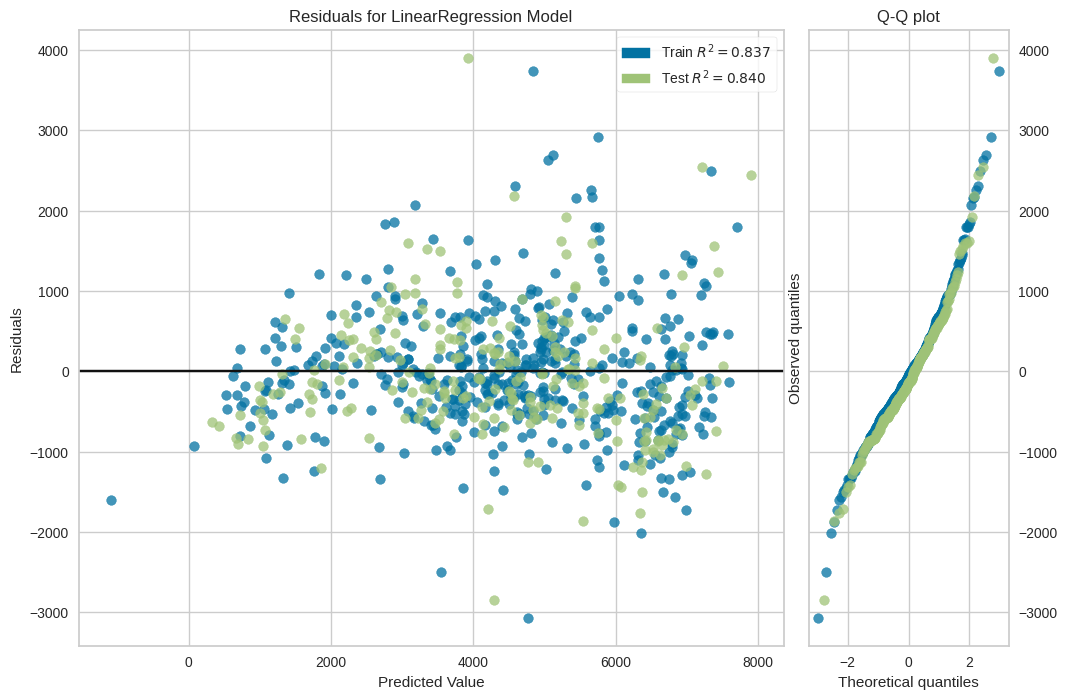

In [ ]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

También podemos representar las predicciones respecto a los valores reales y ver cuánto se desvían de la predicción ideal con el siguiente gráfico:

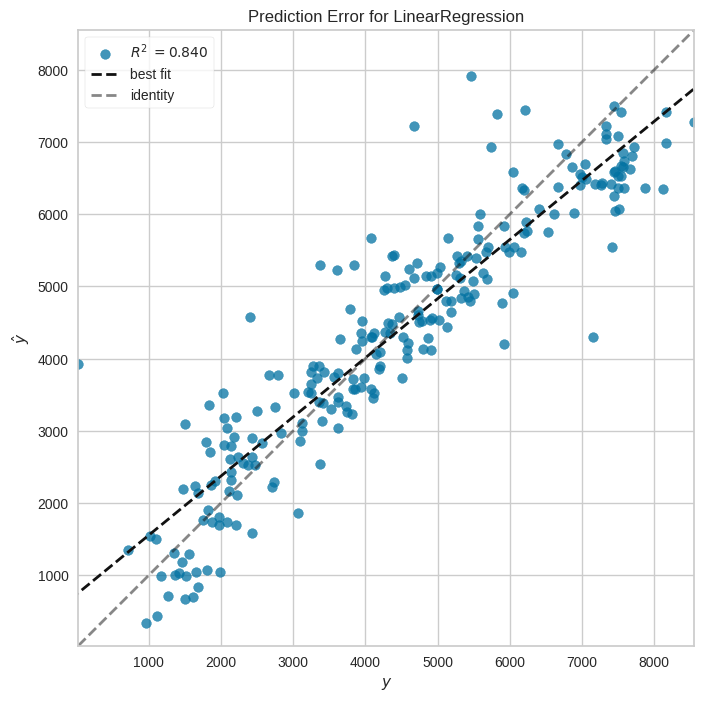

In [ ]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True)
0;

El cual nos indica R² que es la proporción de la variabilidad objetivo que explica el modelo, es decir, la correlación que existe entre el valor real y predecido. En este caso alcanza un valor de 0.840.

## Calidad de la regresión lineal mediante validacion cruzada

Debemos evaluar la eficacia de nuestro modelo, pero hacerlo con los datos de entrenamiento podría llevar a una precisión inflada e irreal. Tampoco es viable utilizar nuestro conjunto de datos de prueba, ya que lo reservamos para una comparación final y objetiva con otros modelos. Este uso final del conjunto de prueba busca imitar el rendimiento del modelo en un escenario real con datos inéditos, permitiéndonos estimar con mayor veracidad el margen de error en situaciones futuras no contempladas durante el entrenamiento.

In [ ]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

r2_score_array = []
nmse_array = []
mse_array = []


kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]));

    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]

    lr = LinearRegression().fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)

    r2_score_array.append(fold_r2)
    mse_array.append(fold_mse)
    nmse_array.append(fold_nmse)

    print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')

    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse,fold_nmse, fold_r2]
    i+=1

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5]
	MSE: 755682.779 NMSE: 0.218 R2: 0.782
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5]
	MSE: 712830.434 NMSE: 0.186 R2: 0.814
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5]
	MSE: 647970.983 NMSE: 0.177 R2: 0.823
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5]
	MSE: 851035.272 NMSE: 0.262 R2: 0.738
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4]
	MSE: 469984.885 NMSE: 0.127 R2: 0.873


Donde MSE es el error cuadrático medio, norm_MSE el error cuadrático normalizado y R2 el coeficiente de determinación.

In [ ]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

,MSE,norm_MSE,R2
Fold 1,755682.779178,0.217973,0.782027
Fold 2,712830.434244,0.18614,0.81386
Fold 3,647970.982626,0.177159,0.822841
Fold 4,851035.271922,0.262035,0.737965
Fold 5,469984.885064,0.127139,0.872861
Mean,687500.870607,0.194089,0.805911


In [ ]:
print(np.mean(np.array(r2_score_array)))
print(np.mean(np.array(mse_array)))
print(np.mean(np.array(nmse_array)))

0.8059108762467048
687500.8706066553
0.19408912375329526


A partir de la media de los cinco folds podemos observar que la calidad es regularmente buena, ya que MSE normalizado es de media 0.19 que se aproxima al 0 y R2 alcanza un 0.872861, siendo la media 0.805911.

Ahora veremos el resultado con el conjunto de test:

In [ ]:
lr_val = LinearRegression()
lr_val.fit(X_train, y_train)
lr_y_pred_val = lr_val.predict(X_test)
lr_r2_val = r2_score(y_test, lr_y_pred_val)
lr_mse_val = mean_squared_error(y_test, lr_y_pred_val)
lr_nmse_val =  1-r2_score(y_test, lr_y_pred_val)
print("R2 test set:", lr_r2_val)
print("MSE test set:", lr_mse_val)
print("NMSE test set:", lr_nmse_val)

R2 test set: 0.8400749268262979
MSE test set: 622081.3418916744
NMSE test set: 0.15992507317370208


Vemos cómo el resultado del R2 con el conjunto de test es de 0.840, ligeramente mejor que con PoissonRegression, el cuál era de 0.827.



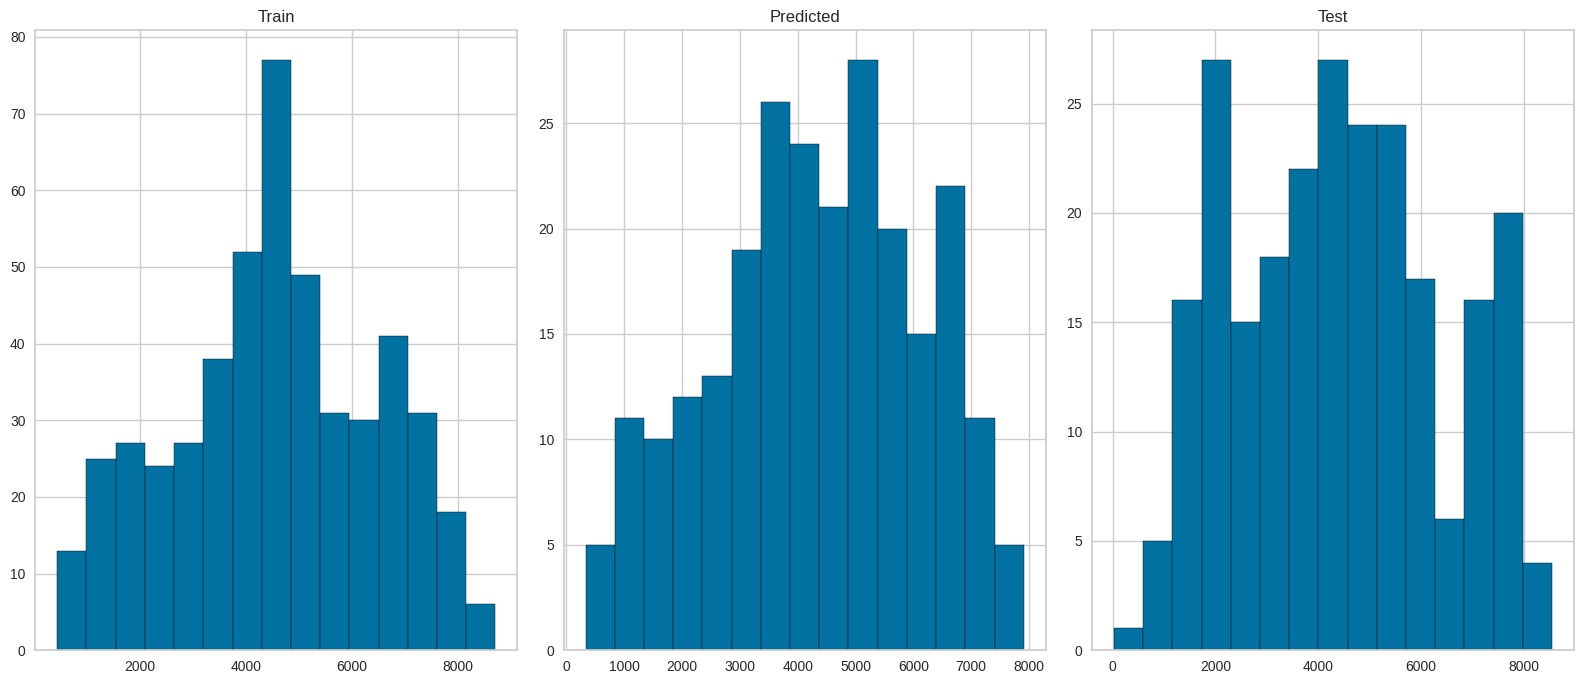

In [ ]:
lr_y_pred_val = pd.Series(lr_y_pred_val);

plt.figure(figsize=(16, 7));

plt.subplot(1, 3, 1);
plt.title("Train");
y_train.hist(bins=15, edgecolor='black');

plt.subplot(1, 3, 2,);
plt.title("Predicted");
lr_y_pred_val.hist(bins=15, edgecolor='black');

plt.subplot(1, 3, 3);
plt.title("Test");
y_test.hist(bins=15, edgecolor='black');

plt.tight_layout();

# Apartado E

# Regresión LASSO

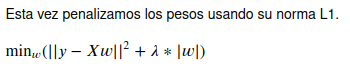

In [ ]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,40,50,55,70,75,80,85,100]

lasso_cv = LassoCV(alphas=lambdas, cv=5, tol = 0.05).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.5 R2 score: 0.8063963504103349


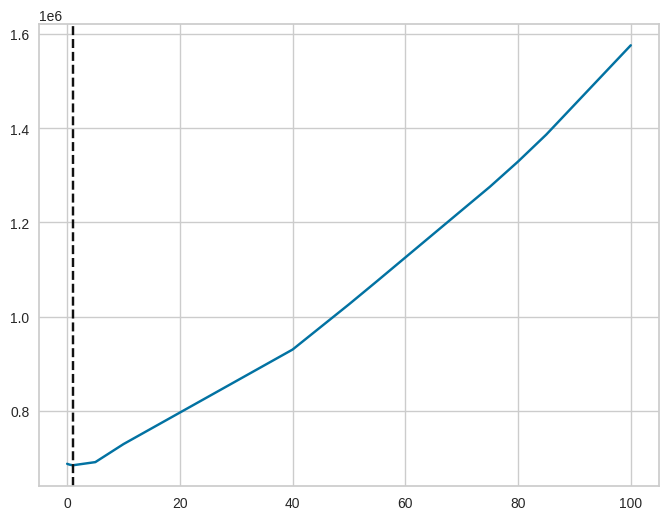

In [ ]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

<Axes: title={'center': 'Modal Coefficients Lasso'}>

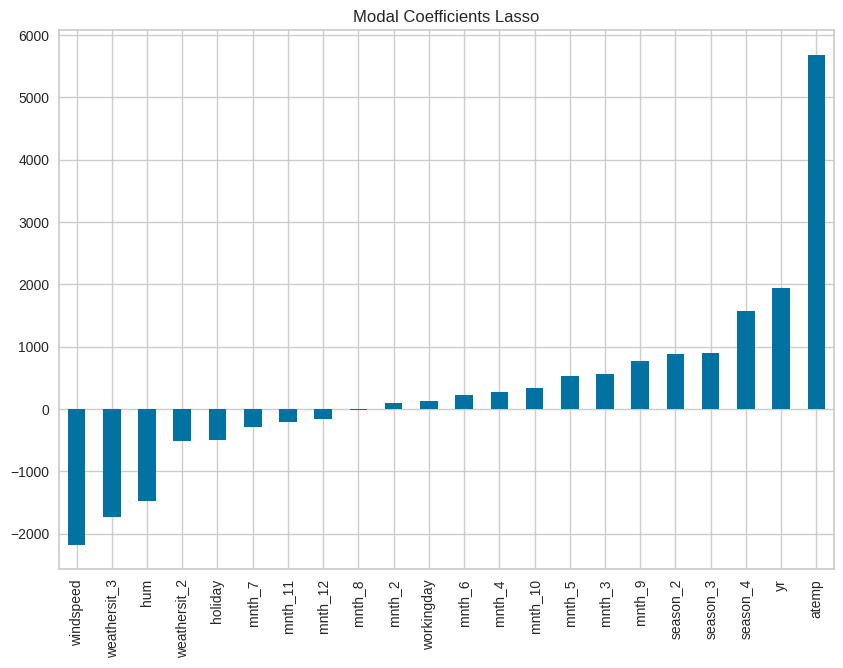

In [ ]:
predictors = X_train.columns

coef = pd.Series(lasso_cv.coef_,predictors).sort_values()

plt.figure(figsize=(10, 7));
coef.plot(kind='bar', title='Modal Coefficients Lasso')

In [ ]:
lasso_val = Lasso(alpha=lasso_cv.alpha_)
lasso_val.fit(X_train, y_train)
lasso_y_pred_val = lasso_val.predict(X_test)
lasso_r2_val = r2_score(y_test, lasso_y_pred_val)
lasso_mse_val = mean_squared_error(y_test, lasso_y_pred_val)
lasso_nmse_val =  1-r2_score(y_test, lasso_y_pred_val)
print("R2 test set:", lasso_r2_val)
print("MSE test set:", lasso_mse_val)
print("NMSE test set:", lasso_nmse_val)

R2 test set: 0.8401991688654082
MSE test set: 621598.0614849479
NMSE test set: 0.15980083113459176


Podemos ver cómo el resultado del Lasso es igual al del LinearRegression, siendo un coeficiente R2 de 0.840.

# Apartado F
# Análisis y Comparación de resultados

*Comparad los valores pronosticados con los valores reales de los tres modelos y sus calidades. ¿Qué modelo os parece mejor? ¿Por qué?*

Para empezar vamos a comparar los valores pronosticados con los valores reales de los tres modelos y decidir qué modelo nos parece mejor.

Los valores obtenidos en los modelos después de calcular su calidad con los datos del test son los siguientes:

PoissonRegressor: 0.825
Linear Regression: 0.840
Lasso: 0.840

Podemos ver que el valor de la regresión con Poisson es la peor aunque era la que de primeras quizás parecía más adecuada para el problema, de todas maneras no se queda muy alejada de las otras dos.
En cuanto a la regresión lineal y Lasso, tienen valores idénticos y a continuación analizaremos los pesos de ambas y los compararemos. Podríamos decir que cualquiera de estos modelos sería el mejor a simple vista por sus valores iguales.



*Analizad los pesos de la regresión lineal y LASSO. ¿Qué atributos son más importantes?¿Hay atributos que no son relevantes?*

Podemos ver que Lasso asigna un peso de casi 0 al mes de agosto, febrero y junio también le asigna pesos muy bajos a los meses de noviembre, diciembre.
Otra variable a la que vemos que asigna poco peso es a workday como habíamos visto previamente en los heatmaps. En cuanto a la variable que más peso tiene con diferencia es atemp y luego le siguen year, windspeed, weathersit3 y season4. Esto confirma nuestros previos análisis debido a que windspeed tenía mucha correlación inversa, weathersit3 era la que mayor correlación inversa tenía de las del tiempo y season4 tenía bastante correlación positiva.



In [ ]:
weights = pd.DataFrame({'pr':pr_val.coef_, 'lr':lr_val.coef_, 'lasso':lasso_val.coef_},index=X_train.columns)
weights.T

,yr,holiday,workingday,atemp,hum,windspeed,weathersit_2,weathersit_3,season_2,season_3,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
pr,0.433741,-0.114336,0.036611,0.251549,-0.052117,-0.039805,-0.093107,-0.531576,0.273977,0.250542,...,0.180028,0.081359,0.105128,0.027836,-0.109472,-0.018502,0.139468,0.094363,0.024820,0.009821
lr,1949.485652,-503.241181,121.197278,5645.294784,-1514.069911,-2257.586189,-513.167812,-1743.626293,1014.540427,1070.393524,...,530.396623,168.333101,412.485082,96.846940,-455.352804,-172.883617,639.508806,232.247150,-329.248570,-238.485715
lasso,1949.176009,-485.919751,121.887754,5616.122879,-1461.054062,-2154.056708,-517.832137,-1742.586129,1023.923039,1032.570905,...,509.486426,140.590265,391.330852,95.710641,-411.578849,-131.337560,664.723829,249.923252,-301.279484,-224.674616


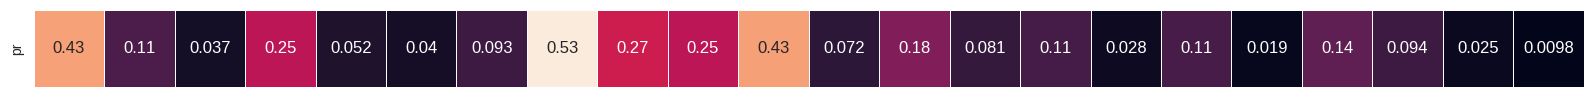

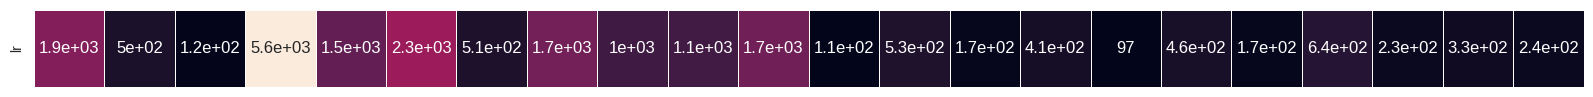

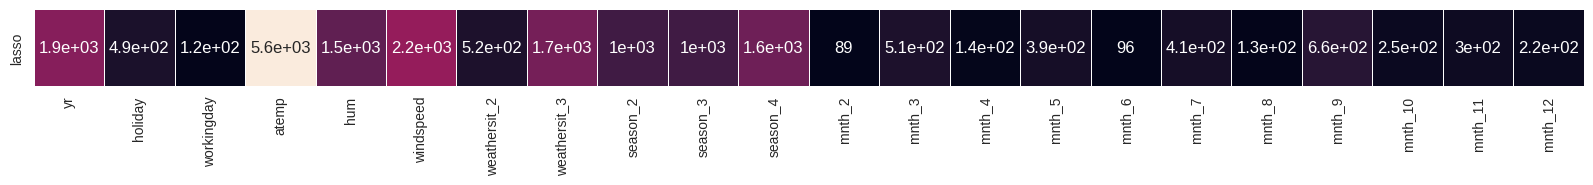

In [ ]:
fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['pr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lasso'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

*Comparad las predicciones de la regresión de Poisson y la regresión de LASSO. ¿Hay alguna diferencia en su comportamiento? ¿Qué creéis que está pasando?*

Poisson va peor que Lasso y podemos suponer que es por cómo distribuye los pesos la regresión de Poisson. La diferencia más importante es que le asigna un peso a atemp bastante bajo en comparación a Lasso, podemos ver que le asigna la mitad de peso que a weathersit3, el mismo peso que a algunas seasons e incluso menos que a season4. Otra diferencia es que a windspeed apenas le asigna peso a diferencia de Lasso donde windspeed es basante importante.